In [49]:
#导入所用的工具包
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb_model
from sklearn.metrics import roc_auc_score
from mlens.visualization import corrmat
import matplotlib.pyplot as plt
import seaborn as sns
from mlens.ensemble import SuperLearner
# 画ROC曲线对模型性能进行比较
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


In [8]:
import os
os.getcwd()

'C:\\Users\\Administrator\\Desktop\\时间序列策略\\参数优化代码\\notebook'

In [10]:
data = pd.read_excel(r"./模型算法-02-Quantum One 面试数据集.xlsx")#读取数据，后面有数据链接
SEED = 123#设立随机种子以便结果复现
np.random.seed(SEED)
# data.info()#查看数据基本信息
data = data.drop(["最近一次登录ip","用户注册渠道"],axis=1)#考虑到用户注册渠道变量缺失值太多，直接删除，然后最近一次登录IP没有对它解析，这个也暂时删除掉。
data = data.fillna(method='pad')#填补缺失值，用的是pad平滑数据的方法，一定要记得加method=哦，要不然有时候会把pad当做字符串填进去的
# data.info()#再次查看数据信息，缺失值填充完毕
#用describe方法查看哪些变量需要离散化，一般是float对象都需要离散化
data[["年龄","投资等级","首投距今时间（天）","最近一次投资距今时间（天）","首投距注册时长（天）","投资金额"]].describe()
def split0(x,col):
    if  np.percentile(col,25)>x>=min(col):
        x="a"
    elif np.percentile(col,50)>x>=np.percentile(col,25):
        x="b"
    elif np.percentile(col,75)>x>=np.percentile(col,50):
        x="c"
    else:
        x="d"
    return x    #不能少
for y in ["年龄","投资等级","首投距今时间（天）","最近一次投资距今时间（天）","首投距注册时长（天）"]:
    data[y]=data[y].apply(lambda x:split0(x,data[y]))
for i in data.columns:
    if re.search("是否",i):
        data[i]=data[i].map({"是":1,"否":0})
def match_col(x):
    if re.search("2015",x):
        x=0
    elif re.search("2016",x):
        x=1
    else:pass
    return x
for i in data.columns:
    if re.search('日期',i) or re.search('时间',i):
        data[i]=data[i].apply(lambda x: match_col(x))
        print("匹配了这些列",i)

def split2(x):
    if re.search("iphone",x):
        x="a"
    elif re.search("HUAWEI",x):
        x="b"
    elif re.search("Xiaomi",x):
        x="c"
    else:x="d"
    return x
data["最近一次登录设备"]=data["最近一次登录设备"].apply(split2)
Y=data.pop("投资金额")
#为了后面用梯度下降法计算w，所以这里需要reshape为2维
Y=pd.DataFrame(Y.values.reshape((5000,1)))
X=pd.get_dummies(data[data.columns.drop("用户id")])
X=X.add(np.ones(len(X)),axis=0)#增加偏置列，默认为1
def scale(x):#进行数据标准化，防止过拟合
    x=(x-x.mean())/(x.std()+0.0001)
    return x
X=X.apply(scale,axis=0)


匹配了这些列 注册时间
匹配了这些列 最近一次登录时间
匹配了这些列 开通托管日期
匹配了这些列 首次充值日期
匹配了这些列 首投时间
匹配了这些列 首投距今时间（天）
匹配了这些列 最近一次投资距今时间（天）


In [16]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=SEED)#划分数据集
print(x_test.head())

      最近一次登录时间    是否开通托管  本月是否有大额回款  是否访问7天内注册  是否注册7天内充值  是否注册7天内投资  \
2648       0.0  0.014043   1.324289  -0.212361  -0.626811   0.675085   
2456       0.0  0.014043   1.324289  -0.212361  -0.626811   0.675085   
4557       0.0  0.014043  -0.754657  -0.212361   1.594349  -1.480360   
4884       0.0  0.014043  -0.754657  -0.212361  -0.626811   0.675085   
92         0.0  0.014043   1.324289  -0.212361  -0.626811   0.675085   

      是否托管7天内充值  是否托管7天内投资  是否充值7天内投资      年龄_a  ...  用户浏览产品期限倾向(月）_7-12  \
2648  -0.507624   0.558991  -1.277484 -0.545117  ...           -0.655381   
2456  -0.507624   0.558991   0.782310  1.833229  ...            1.524861   
4557   1.968592  -1.787740   0.782310  1.833229  ...            1.524861   
4884  -0.507624   0.558991  -1.277484  1.833229  ...           -0.655381   
92    -0.507624   0.558991   0.782310 -0.545117  ...            1.524861   

      用户浏览产品利率倾向_(0,4%]  用户浏览产品利率倾向_(4%,5.5%]  用户浏览产品利率倾向_(5.5%,6%]  \
2648          -0.145629              0.

In [17]:
def linear_regression_by_gd(X, Y, gamma=0.000001, eps=0.0001, max_iter=100): #梯度下降求线性回归
    pre_w = np.array(np.ones((X.shape[1], 1)))
    cur_w = np.array(np.zeros((X.shape[1], 1)))
    count = 1
    while (cur_w - pre_w).T.dot(cur_w - pre_w) > eps and count < max_iter:
        pre_w = cur_w
        cur_w = cur_w - np.array(gamma / np.sqrt(count) * X.T.dot( X.dot(cur_w) - Y))
        count += 1
    return cur_w

w = linear_regression_by_gd(x_train, y_train)


y_train=2**(y_train > Y.median()) -1#将连续目标变量转换为2分类变量,median表示中位数值
y_train1 = np.ravel(y_train)
y_test=2**(y_test > Y.median()) -1
y_test1 = np.ravel(y_test)

In [19]:
def get_models():
#"""Generate a library of base learners."""
    nb = GaussianNB()#朴素贝叶斯
    svc = SVC(C=1,random_state=SEED,kernel="linear" ,probability=True)#kernel选用线性最好，因为kerenl太复杂容易过拟合，支持向量机
    knn = KNeighborsClassifier(n_neighbors=3)#K近邻聚类
    lr = LogisticRegression(C=100, random_state=SEED)#逻辑回归
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)#多层感知器
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)#GDBT
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)#随机森林
    etree=ExtraTreesClassifier(random_state=SEED)#etree
    adaboost=AdaBoostClassifier(random_state=SEED)#adaboost
    dtree=DecisionTreeClassifier(random_state=SEED)#决策树
    lightgbmlgb=lgb_model.sklearn.LGBMClassifier(is_unbalance=False,learning_rate=0.04,n_estimators=110,max_bin=400,scale_pos_weight=0.8)#lightGBM，需要安装lightGBM，pip3 install lightGBM

    models = {
              'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              'etree': etree,
              'adaboost': adaboost,
              'dtree': dtree,
              # 'lgb': lightgbmlgb,
             }
    return models

def train_predict(model_list):#预测
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(x_train, y_train1)
        P.iloc[:, i] = m.predict(x_test)
        cols.append(name)
        print("done")
    P.columns = cols
    print("ALL model Done.\n")
    return P

def score_models(P, y):#打印AUC值
#"""Score model in prediction DF"""
    print("Scoring AUC的值models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [21]:
base_learners = get_models()
P = train_predict(base_learners)
score_models(P, y_test1)


Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... 

D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done
etree... 

D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done
adaboost... done
dtree... done
ALL model Done.

Scoring AUC的值models.
svm                       : 0.888
knn                       : 0.585
naive bayes               : 0.832
mlp-nn                    : 0.846
random forest             : 0.750
gbm                       : 0.902
logistic                  : 0.870
etree                     : 0.891
adaboost                  : 0.888
dtree                     : 0.882
Done.



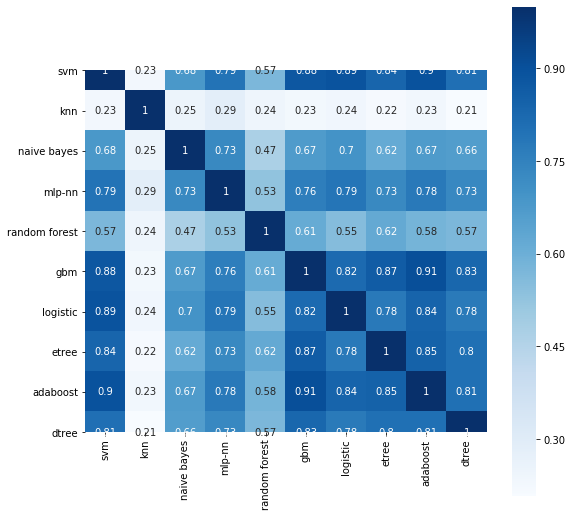

In [47]:
# corrmat(P.corr(), inflate=False)
# plt.show()
P = P.astype('float')

# corrmat([[1,1],[2,2]], inflate=False)
plt.subplots(figsize=(9, 9))
sns.heatmap(P.corr(), annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

In [48]:
# 定义元学习器GBDT

meta_learner = GradientBoostingClassifier(

    n_estimators=1000,

    loss="exponential",

    max_features=3,

    max_depth=5,

    subsample=0.8,

    learning_rate=0.05,

    random_state=SEED
)

meta_learner.fit(P, y_test1)#用基学习器的预测值作为元学习器的输入，并拟合元学习器，元学习器一定要拟合，不然无法集成。


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='exponential', max_depth=5,
                           max_features=3, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=123, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [51]:
#5折集成
sl = SuperLearner(
    folds=5,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

sl.add(list(base_learners.values()), proba=True) # 加入基学习器
sl.add_meta(meta_learner, proba=True)# 加入元学习器
# 训练集成模型
sl.fit(x_train[:1000], y_train1[:1000])
# 预测
p_sl = sl.predict_proba(x_test)
print("\n超级学习器的AUC值: %.3f" % roc_auc_score(y_test1, p_sl[:, 1]))






Fitting 2 layers
Processing layer-1             done | 00:01:00
Processing layer-2             done | 00:00:01
Fit complete                        | 00:01:03

Predicting 2 layers
Processing layer-1             done | 00:00:17
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:18

超级学习器的AUC值: 0.964


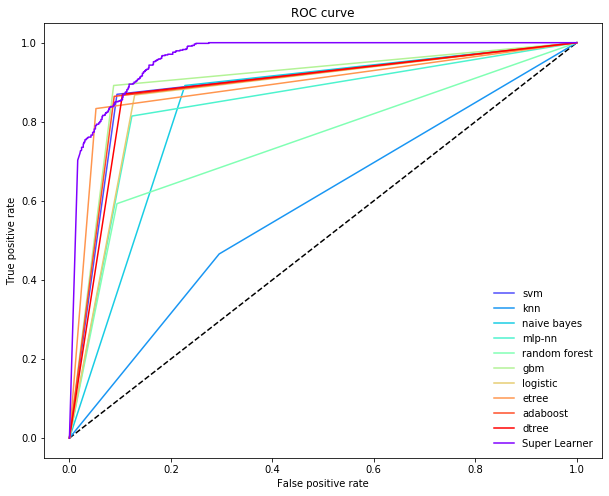

In [52]:
#画roc曲线
def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):

    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])
    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right",frameon=False)
    plt.show()

plot_roc_curve(y_test1, P.values, p_sl[:,1], list(P.columns), "Super Learner")
